<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/notes/01_notes_FastMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes on MRI -> k space -> image

# Setup

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Set path to proj
PROJ       = "fastmri"

ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
GDRIVE_PATH   = ALL_PROJ_PATH/PROJ                  # path to project on GDrive
GDRIVE_PATH.mkdir(parents=True, exist_ok=True) # make dir in Gdrive to house Github

%cd "$GDRIVE_PATH"

Path.BASE_PATH = GDRIVE_PATH
%pwd

/content/drive/My Drive/fastai_proj/fastmri


'/content/drive/My Drive/fastai_proj/fastmri'

In [3]:
!git pull  # Refresh repo

Already up to date.


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

In [0]:
from functools import partial

img_dir = "notes/imgs"

# useful fn to plot image fnames in *args
def plot(img_dir, *args, nrows=1, ncols=1, figsize = (6,6), **kwargs):
  print(kwargs)
  fig,axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, **kwargs)
  axes = axes.flatten()
  for i,fn in enumerate(args): axes[i].imshow(Image.open(f"{img_dir}/{fn}"))
  fig.show()

img_plot = partial(plot,img_dir)

# Background sources

- XRay Physics: http://xrayphysics.com/spatial.html
- Harvey Mudd - http://fourier.eng.hmc.edu/e161/lectures/fourier/node10.html

- Intro to Computer Vision UC - https://slideplayer.com/slide/6240958/

- Practical fMRI blog: https://practicalfmri.blogspot.com/2012/02/physics-for-understanding-fmri.html

- Mt Sinai talk: https://www.youtube.com/watch?v=QHtZR0mtB80&t=711s

- Lecture at Albert Einstein School of Medicine: Einstein Colllege of Medicine - https://www.youtube.com/watch?v=03x4xdUBo_Q

- Wiki: https://en.wikipedia.org/wiki/K-space_(magnetic_resonance_imaging), https://en.wikipedia.org/wiki/Frequency_domain

- High School Physics Explained: https://www.youtube.com/watch?v=C_SidedXNQ4&t=1s

- MRI Questions & Answers: http://mriquestions.com/locations-in-k-space.html, http://mriquestions.com/what-are-2d---3d-fts.html

- University of Oxford: http://www.robots.ox.ac.uk/~az/lectures/ia/lect2.pdf

<!-- Some others: 

- Physics lecture (gradient magnetic field): https://www.youtube.com/watch?v=XJvVnlMv1LQ

- wiki: https://en.wikipedia.org/wiki/K-space_(magnetic_resonance_imaging)

- quick summary:  https://www.youtube.com/watch?v=9qgUP8IJePA -->

# Fourier Transform

Fourier transforms in general are a change-of-basis to frequencies (= reciprocal units):

Original Domain | FT Domain = Reciprocal | Description
--- | --- | ---
time (s) | Hz (1/s) | #cycles per sec
length (cm) | wavenumber $k$ (1/cm) | #cycles per cm

For a 1d signal $S = f(x)$:
- All signals $S$ can be expressed as a sum of sinusoid waves, where each wave is defined by its (angular) frequency $\omega$, phase $\phi$, and amplitude $A$: s(x) = $A \sin(\omega x + \phi$).
- FT converts a signal to the set of sinusoid waves that compose it, representing each sinusoid wave on axes where
  - domain = frequency $\omega$ (units reciprocal to orignal domain)
  - target = $FT(\omega)$ = complex number $c \in \mathbb{C}$. In polar form $c = Ae^{i\phi}$ where A, $\phi$ are the wave's amplitude and phase
- Adding two sinusoid waves of the same freq $\omega$ results in a sinusoid wave with 
  - the same freq $\omega$ 
  - but amplitude/phase vary (depending whether the component waves interact with constructive/destructive interference).

For a 2d signal$ S = f(x,y)$,
- All signals $S$ can be expressed as a sum of planar sinusoid waves defined by freq $\omega$, direction $\theta$, amplitude $A$, phase $\phi$
- FT converts a signal to the set of sinusoid waves that compose it, representing each sinusoid wave on axes where
  - domain = spatial frequencies $(u,v)$, which in polar coordinates represent the sinusoid's

    - frequency $\omega = \sqrt{u^2 + v^2}$, and 
    - direction $\theta = \arctan(v/u)$. 

- The complex number $FT(u,v) = c \in \mathbb{C}$ still represents the sinusoid's amplitude & phase in polar coord.

- Adding two sinusoid waves of the same (freq $\omega$, direction $\theta$) results in a sinusoid wave with 
  - the same freq $\omega$, direction $\theta$ 
  - but amplitude/phase vary (constructive/destructive interference). 

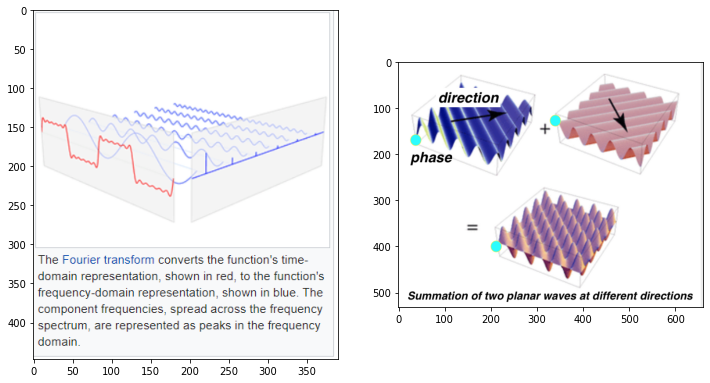

In [0]:
img_plot("Fourier transform.png", "directions.png", ncols=2, figsize=(12,12))

# K space

K space: represents Fourier transform of a *spatial* function (i.e. original fn has axis units of cm, so axis units of FT is 1/cm = wavenumber $k$).

Each k-space location ($kx, ky) =  (\omega,\theta)$ in polar coordinates in a k-space image defines a specific sinusoid wave (called stripe pattern).

In terms of $(\omega,\theta)$:
- $\theta$ specifies the stripe's direction
- $\omega$ specifies the stripe's width (sinusoid frequency)
  - Center: 
    - lower freq
    - wider stripes
    - patterns that change slowly across space
    - gross features
  - Periphery: 
    - higher freq
    - narrower stripes
    - patterns that change a lot across space
    - finer details like edges

The complex number $c =  Ae^{i\phi}$ at each $k$-space location $(kx,ky)$ represents the sinusoid's  
1. amplitude/intensity $A$ (how strong is the stripe signal)
2. phase (where to start in the infinite stripe pattern/sine wave).

Source: Mt Sinai talk, Harvey Mudd



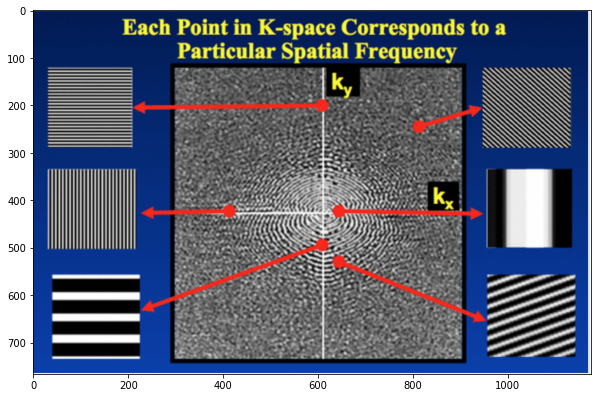

In [0]:
img_plot("kspace_point.png", figsize=(10,10))

# MR: Producing signal 

"The MR signal is a small electrical current induced in the receiver coil by the precession of the net magnetization (M) during resonance."

1. Initial state: protons are in a uniform magnetic field $B_0$
  - protons spin w/angular freq $w_0$ (Larmor, $w \propto B$) 
  - protons precess randomly $\to$ cancel each other out $\to$ no net precession

2. 90&deg; excitation RF pulse at resonance freq: protons resonate in phase $\to$ individual precessions sum toegther $\to$ net precession around dipole $M$

3. During readout, receiver coils record $M_{xy}$ signal as $M$ precesses at resonance freq

{'gridspec_kw': {'width_ratios': [1, 1.15]}}


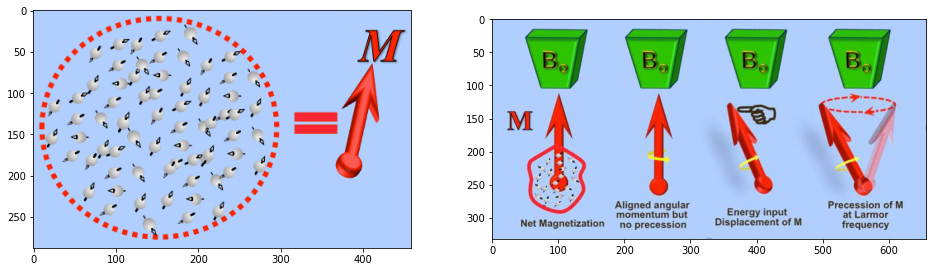

In [54]:
gridspec_kw = {"width_ratios": [1,1.15]}
img_plot("net_m.gif", "precession.jpg", \
           ncols=2, figsize=(16,16), gridspec_kw=gridspec_kw) # src = MRI questions & answers


# MR: Localization

By default, all protons precess at same resonance freq. How can we create a signal where we can seperate components of $M_{xy}$ according to $xy$ spatial location?



### x-axis localization: frequency encoding

After applying excitation RF pulse, protons are all precessing at same resonance frequency. During readout, we  apply a small magnetic field gradient in the x-axis $G_x$ so that
  - each proton's magnetic field depends on $x$: $B_x = G_x x$, 
  - each proton's resonance freq depends on $x$: $w_x = \gamma G_x x$ 
  - FT on signal $S$ captured during readout yields $M(f)$ for each freq $f$ returned by FT ($f$ is stepped in discrete values).
    - each freq $f$ corresponds to an $x$-axis slice so we have $M(x)$ for each $x$-axis slice. 
  - The amplitude of the magnetization vector
    - $M(x) \propto$ no. protons who precess at freq $f$ 
    - $M(x) \propto$ no. protons in x-axis slice

  yields a 1d cross section of the object.


{}


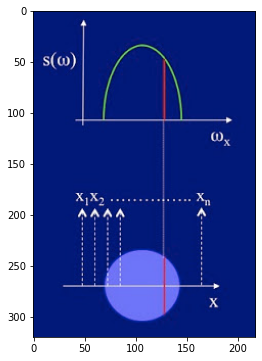

In [56]:
img_plot("profile.jpg")

Notes:

- Signal $M$ is analog, we sample it at discrete time points to digitize it. The freq with which we sample is called the bandwidth. 
  - High freqs in the signal - i.e. freq so high that we sample < 2 points per cycle) cannot be distinguished from lower-freq signal and are aliased, e.g. car wheel appears to rotate backwards.

- protons w/diff precession freq $\to$ phase gets out of sync over time (accrue phase shift) $\to$ precessions to cancel each other out in signal $M$. To solve this use gradient echo:
  - from $t = 0$ to $t = 1$: apply gradient $G_x$, causes accrued phase shift.
  - from  $t = 1$ to $t = 2$: apply reverse gradient -$G_x$, reverses the accrued phase shift. Signal is strongest here (no dephasing) = "top of echo."
  - $t = 2$ to $t = 3$: -$G_x$ causes phase shift that mirrors the phase shift from $t = 0$ to $t = 1$.

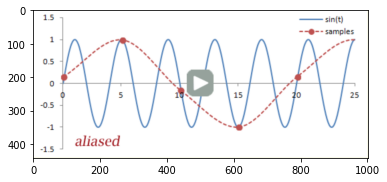

In [0]:
img_plot("alias.png")

## kx encoding

Consider the magnetization vector $M(x)$ arising from a $x$-axis slice. Due to the $x$-axis gradient, the $M(x)$ precesses at freq $\omega = \gamma \int G_x(x) dx$. For constant $G_x$, $\omega = \gamma G_x x$.
- At time $t=0$, there is no phase shift relative to a magnetization vector precessing at freq $w_0$.
- Over time, $M(x)$ accruess the phase shift is $e^{i\omega t}$.

The signal from $M_x$ at time $t$ is $S(t) = \int_{-\infty}^{\infty} M(x) e^{i\omega t} dx$. 
- Define $k_x (t)= \gamma \int G_x(t) dt$ . For constant $G_x$,
  - $k_x(t) = \gamma G_x t$
  - $\omega t = k_x x$ (note $k_x$ is in units of 1/cm).
- Rewritten, $S(k_x) = \int_{-\infty}^{\infty} M(x) e^{i k_x x} dx$ 
  - This is the k-space FT of an image (units of axes are cm)!

So now we know the value of $S(k_x)$ --  it is the net sample magnetization when gradient $G_x$ has been applied for time $t$. We get a row of $k_x$ values by observing the signal as the $G_x$ gradient plays out over time.

## y-axis localization: phase encoding

After applying excitation RF pulse, protons are all precessing at same resonance frequency. 

- Before readout, turn on a y-axis magnetic field gradient $g_y$ for a fixed short time $t_p$ so that
  - each proton's magnetic field depends on $y$: $B_y = g_y \cdot y$, 
  - each proton's precession freq depends on $y$: $w_y = \gamma \cdot g_y \cdot y$ 


- Turn off y-axis gradient: protons at different y-locations have accumulated phase shift.
- During readout, turn on x-axis gradient. Protons now precess at freq depending on x-axis location, but "remember" their accumlated phase shift that depended on their y-axis location.

But FT cannot distinguish waves of the same freq but different phase -- 
so to distinguish phases we repeat the procedure with phase-encoding gradients of different strengths $g_y$ and measure phase shift for each.


Knowing how different $g(y)$ phase shifts effect the amplitude of the $M(x)$ signal enables us to determine the freq & phase of the magnetization vector $M_{xy}$ at each location (x,y).

Source: Xray physics & MRI questions

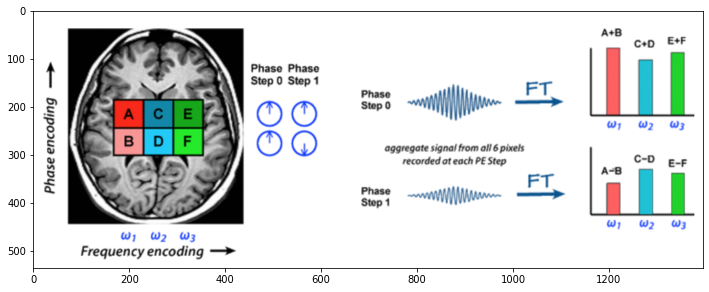

In [0]:
img_plot("phase_encoding.png", figsize=(12,20))

## ky encoding

Including a before-readout phase increment caused by applying $g_y$ and defining $k_y = \gamma \int_{g_y = 0}^{g_y = G_y} t_p dg_y$, 
- $S(k_x, k_y) = \int_{-\infty}^{\infty} M(x,y) e^{i k_x x} e^{i k_y y} dx dy$. 

For constant $t_p$, $k_y = \gamma t_p g_y$, so now we know how to increase $ky$ -- increase $g_y$.

## MR: k-space

Together $kx$ and $ky$ recreate $k$ space for the image.

Img sources = (Lecture at Albert Einstein, Mt Sinai talk)

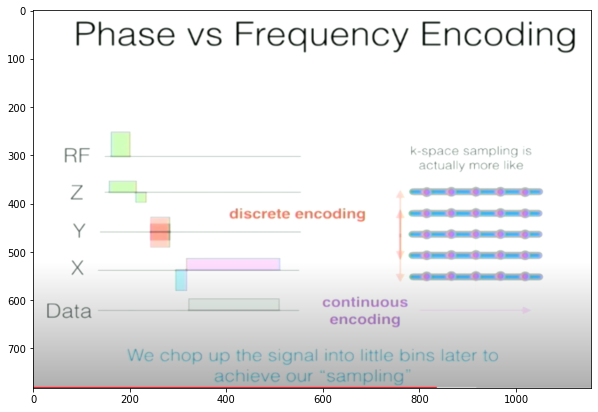

In [0]:
# img sources = (Lecture at Albert Einstein, Mt Sinai talk)
img_plot("discrete_vs_cont.png", figsize = (10,10))

# MRI -> k space vs. Regular Image -> k space:

Both are sparse: only sinusoids/stripe patterns present in the signal/image have non-zero intensity, so most pixel values in kspace are zero.

Both have pixel/stripe activations clustered in the center than in the periphery, but for different reasons: 

- MRI k space images: "Near to the center of k-space the signal is high because the amount of phase applied by the imaging gradients to the sample magnetization is low; the degree of signal cancellation is low." -from fmRI blog

- "the more different frequencies and phases present in a signal, the smaller the total signal, especially over time (see the top right panels in the simulations, the gray line represents the total signal). This is just because the signals get out of sync with each other over time if their frequencies are different - and thus, the valleys and peaks start to cancel each other out. A phase shift makes the signals out of sync from the very beginning, making the 'cancellation' even more apparent." -from Xray physics


- "The image of the Hurricane contains more broad areas of relatively uniform intensity - clouds in the sky, the grass, large blobs of camouflage painted on the wings and fuselage, etc. - than it does edges and other fine details. And since we now know that edges live in peripheral (high) k-space regions whereas spatially broad features live towards the center of k-space, we can consider the k-space plot as a kind of "spatial content map." There is simply more image content to map that changes slowly with distance than there is content that changes rapidly with distance (i.e. detail)." 

Source: fMRI blog part 15

Question: 

5. Is MRI k space data actually different from regular image in k space data? I think it is the same as both ultimately represent images -- if MR freq/phase axes can be interpreted in terms of kspace freq/direction axes, then don't pixel activations in the center just mean that the image represented in kspace has more content that changes slowly with distance than content that changes rapidly with distance?



## Encoding Parameters
1. Resolution = how fine stripe patterns are 

 = farther out from origin 
 
 = furthest extent of k-space
 
 = largest magnitude of (kx,ky) = (freq, phase) values


2. Field of View = how many pixels in constructed image 

 = "more measurements" (no. of equations = no. of unkowns)

 = denser k-space sampling (sample more values of ky and kx within the given range of kx,ky values). Note: since we can sample as densely as we want in kx without time penalty, can have arbitrarily large FOV in x direction. 


3. Bandwidth = how frequently to sample time points in the echo response signal (units of kHz or normalized by Hz/pixel). 

 Changing bandwidth (how well we digitize echo/how many freq can be detected in FT) while 
  - holding image resolution (range of kx/ky values) constant and 
  - holding FOV (density i.e. step size of kx/ky values) consant 

results in faster output but also higher levels of noise relative to signal.

 Questions about bandwidth:
 is higher levels of noise due to aliasing?

 Sources: Mt Sinai Talk, fMRI blog post

# Questions 

1.-5. Cntrl+F "Question"

#fin

In [57]:
!git pull  # Refresh repo

Already up to date.


In [0]:
# !rm .git/index.lock

In [59]:
!git status        # Check statuses of changed files
!git add --all     # Add/track files

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   notes/01_notes_FastMRI.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	notes/ideas.ipynb
	notes/imgs/mxy.jpg
	notes/imgs/net_m.gif
	notes/imgs/precession.jpg
	notes/imgs/profile.jpg

no changes added to commit (use "git add" and/or "git commit -a")


In [60]:
!git commit -am "add ideas"    # Commit msg
!git push origin master # Push changes to Github repo


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@d5b8b5449f42.(none)')
Everything up-to-date


In [0]:
# !rm .git/index.lock

In [0]:
!git status        # Check statuses of changed files
!git add --all     # Add/track files
!git commit -m "msg" # Commit msg
!git config --global user.email "rachel.gologorsky@gmail.com"
!git config --global user.name "Rachel Gologorsky"

!git remote -v # print pull/push URLs


On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   notes/01_notes_FastMRI.ipynb
	new file:   notes/ideas.ipynb
	new file:   notes/imgs/mxy.jpg
	new file:   notes/imgs/net_m.gif
	new file:   notes/imgs/precession.jpg
	new file:   notes/imgs/profile.jpg

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   notes/01_notes_FastMRI.ipynb


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@d5b8b5449f42.(none)')


In [0]:
!git push origin master # Push changes to Github repo

In [0]:
# !rm .git/index.lock